In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from tqdm import tqdm
import json

from datasets import load_dataset, Image

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import sys
sys.path.append("..")
import config

import aiohttp
import matplotlib.pyplot as plt

In [ ]:
batch_size = config.BATCH_SIZE

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(42)

## Build Combined DOCCI & IIW Dataset

In [4]:
# Prolonged timeout for loading the Google dataset because they are losers who don't host on HuggingFace: https://github.com/huggingface/datasets/issues/7164#issuecomment-2439589751

docci_dataset = load_dataset('google/docci', name='docci', trust_remote_code=True, storage_options={'client_kwargs': {'timeout': aiohttp.ClientTimeout(total=10000)}})

Dataset({
    features: ['image', 'example_id', 'description'],
    num_rows: 9647
})
Dataset({
    features: ['image', 'example_id', 'description'],
    num_rows: 5000
})


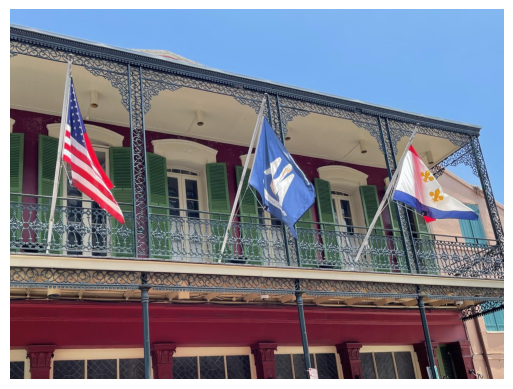

Description:
 A front view of a building with three flags on the balcony of the building from left to right. The flags are blowing in the wind. The flag on the far left is the American flag. The flag in the middle is all blue with a white design on it. White words are underneath the white design. The flag on the far right is red, white and blue with two golden New Orleans Saints logos on it. The window coverings on the windows on the balcony are all green. Five small white lights are protruding from the ceiling over the balcony. The railings of the balcony are all black and metal. A red section of the building is below the balcony. Cream-colored window seals are on the building as well. A clear blue sky is over the building.


In [5]:
print(docci_dataset['train'])
print(docci_dataset['test'])

random_sample = docci_dataset['train'][random.randint(0, len(docci_dataset['train']) - 1)]
plt.imshow(np.array(random_sample['image']))
plt.axis('off')
plt.show()
print('Description:\n', random_sample['description'])

In [6]:
max_desc_length = 0
longest_description = ""

def transform_to_length(examples):
    global max_desc_length, longest_description
    lengths = [len(desc) for desc in examples['description']]
    max_desc_length = max(max_desc_length, *lengths)
    longest_description = max(longest_description, *examples['description'], key=len)


In [7]:
docci_dataset['train'].map(transform_to_length, batched=True, batch_size=batch_size)
print("Max description length after looking at training set:", max_desc_length)
print("Longest description in training set:", longest_description)
docci_dataset['test'].map(transform_to_length, batched=True, batch_size=batch_size)
print("Max description length after looking at test set:", max_desc_length)
print("Longest description in test set:", longest_description)

Map: 100%|██████████| 9647/9647 [00:00<00:00, 945782.12 examples/s]


Max description length after looking at training set: 2136
Longest description in training set: The nose end of a white metro train is facing left and is not in motion. The train is just outside a platform stop that is indoors. The head of the train has large black windows that span almost the entirety of the train that is visible in the image. That train has no sharp angles in its design. The train and its windows are smooth and rounded. A row of automated silver-framed doors remains closed. One door to the left does not have a see-through window like the other doors. The door is second from the left. The window is filled with a white panel with a shiny metallic appearance. The panel contains two framed, vertical rectangles that appear dark, black and hollow. Inside one rectangle to the right are seven lights from something electronic inside. The same number of lights appear in the rectangle to the left, but the lights are dimmed greatly. Just below the panel on that door, another seg

Map: 100%|██████████| 5000/5000 [00:00<00:00, 1058953.75 examples/s]

Max description length after looking at test set: 2840
Longest description in test set: An outdoor medium front view of the Blanco County Courthouse, adorned in Christmas lights. Lights that shine yellow hang from the roof line of the large courthouse, they hang in a strait vertical alignment across the building and slightly past the building due to the roof line extending slightly outward on the left and right of the view. At the top and bottom of the courthouse, the lights take a different shape and design, at the top of the roof the lights are aligned in U shapes across the roof line from left to right. The same U shapes are partially visible at the bottom of the building. Above the roof line is a circular light design attached to a Christmas reef on the roof in the upper middle portion of the view. On the left side of the view more Christmas lights are visible and shine a yellowish color. A large tree with no leaves is visible with numerous lights shining across its trunk, tightly 

In [8]:
# export json for setting MAX_DESC_LENGTH=max_desc_length in config later
with open(os.path.join(config.TOKENIZER_DATA_PATH, "max_desc_length.json"), "w") as f:
    json.dump({"MAX_DESC_LENGTH": max_desc_length}, f)

Decoder self-attention is: $ O(L^2⋅d) $, where L is the sequence length.

For L = 2840:
* Attention matrix per head: $ 2840 * 2840 \approx 8 \text{ million elements} $
* With multiple heads, layers, gradients => VRAM explodes.
* This happens for every batch element.

## Calculate Dataset Statistics

Map: 100%|██████████| 5000/5000 [00:00<00:00, 1522101.90 examples/s]


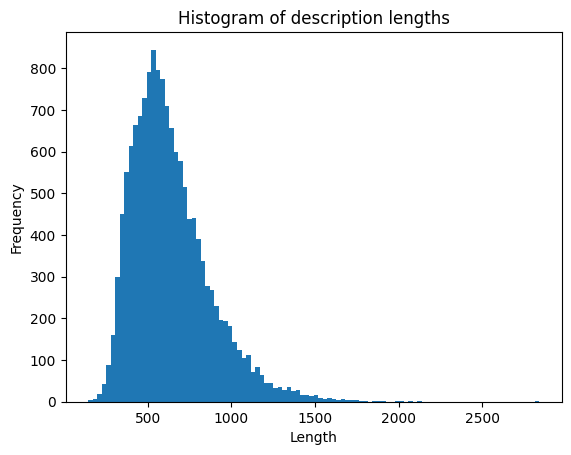

Length mean:  640.0041646753601
Length median:  596.0
Length std:  236.81620852651727
Length max (90th percentile):  956
Length max (92nd percentile):  997
Length max (95th percentile):  1089
Length max (99th percentile):  1394


In [9]:
lengths = []
def collect_lengths(examples):
    global lengths
    lengths.extend([len(desc) for desc in examples['description']])
docci_dataset['train'].map(collect_lengths, batched=True, batch_size=batch_size)
docci_dataset['test'].map(collect_lengths, batched=True, batch_size=batch_size)

plt.hist(lengths, bins=100)
plt.title("Histogram of description lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

mean = np.mean(lengths)
median = np.median(lengths)
std = np.std(lengths)
max_length_90 = int(np.percentile(lengths, 90))
max_length_92 = int(np.percentile(lengths, 92))
max_length_95 = int(np.percentile(lengths, 95))
max_length_99 = int(np.percentile(lengths, 99))
print('Length mean: ', mean)
print('Length median: ', median)
print('Length std: ', std)
print('Length max (90th percentile): ', max_length_90)
print('Length max (92nd percentile): ', max_length_92)
print('Length max (95th percentile): ', max_length_95)
print('Length max (99th percentile): ', max_length_99)

In [10]:
with open(os.path.join(config.TOKENIZER_DATA_PATH, "description_stats.json"), "w") as f:
    json.dump({
        "mean": round(mean),
        "median": round(median),
        "std": round(std),
        "max_90": max_length_90,
        "max_92": max_length_92,
        "max_95": max_length_95,
        "max_99": max_length_99
    }, f)